# Task II - Machine Learning

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from load_data import full_data_load
from helper_functions import generate_markdown_table

# Set some styling for charts and visualisations
plt.style.use("ggplot")
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Set directory to save charts to
CHARTS_DIR = "02 Figures"

## Data Load

Load the data using the code that was already developed for Task I.

In [2]:
ff = full_data_load()
display(ff)

,Firm,Metric,Year,Value
0,Firm 1,NWP (£m),2016,-17754.100486
1,Firm 2,NWP (£m),2016,9.244369
2,Firm 3,NWP (£m),2016,0.000000
3,Firm 4,NWP (£m),2016,19677.453353
4,Firm 5,NWP (£m),2016,128.812208
...,...,...,...,...
33515,Firm 452,Gross combined ratio,2020,0.000000
33516,Firm 453,Gross combined ratio,2020,0.000000
33517,Firm 454,Gross combined ratio,2020,0.352309
33518,Firm 455,Gross combined ratio,2020,4.331669


Further filter the data down to only what we are interested in for this analysis.

In [3]:
# Rename one of the metrics
ff["Metric"] = ff["Metric"].replace("NWP (£m) ", "NWP (£m)")

# Filter to only metrics from the 'General' dataset
general_metrics = ["NWP (£m)", "SCR (£m)", "EoF for SCR (£m)", "SCR coverage ratio", "GWP (£m)", "Total assets (£m)", "Total liabilities (£m)", "Excess of assets over liabilities (£m) [= equity]"]
ff = ff[ff["Metric"].isin(general_metrics)]

# Remove zero values from the DataFrame
ff_removed_zeros = ff[ff["Value"] != 0]

## Handle Missing Values and Erroneous Data

1. Calculate a single value for each firm/metric by taking the most recent non-zero value for each metric
2. Restructure the data into a columnar format typical of machine learning projects
3. Remove any firms that we do not have a value for every metric for
4. Remove any firms that have an erroneously high SCR value

In [4]:
# Calculate a single value for each firm/metric by taking the most recent non-zero value for each metric
ff_sorted = ff_removed_zeros.sort_values(by=['Firm', 'Metric', 'Year'], ascending=[True, True, False])
ff_summary = ff_sorted.drop_duplicates(subset=['Firm', 'Metric'])

# Pivot the data
firms = ff_summary.pivot(index="Firm", columns="Metric", values="Value")

# Drop any firms that we are missing data form
firms = firms[firms.isna().sum(axis=1) == 0]

# Remove firms with erroneously high SCR coverage ratio
firms = firms[firms["SCR coverage ratio"] < 30]

firms

Metric,EoF for SCR (£m),Excess of assets over liabilities (£m) [= equity],GWP (£m),NWP (£m),SCR (£m),SCR coverage ratio,Total assets (£m),Total liabilities (£m)
Firm,,,,,,,,
Firm 10,8207.819857,9062.225268,882.479158,221.986516,1773.693684,0.598787,195835.579311,254270.412386
Firm 100,65.980958,71.114779,29.951861,55.765640,70.577824,0.205001,9.149835,134.552953
Firm 101,3133.622320,10807.461907,4418.482952,4804.131318,3369.613372,1.875703,14345.263861,187041.541791
Firm 104,30.990390,60.000927,5256.831640,6174.582162,3.682384,2.240161,5368.977021,29518.369746
Firm 105,17153.676326,14418.773141,5857.037438,2612.553473,18335.571950,1.171555,105212.731922,175127.630729
...,...,...,...,...,...,...,...,...
Firm 93,1.211513,52.726004,0.753979,1.230475,33.003865,5.606870,184.400230,12.733462
Firm 95,17.213553,33.044518,0.017498,0.003770,0.673003,20.392243,50.566186,0.052536
Firm 96,16.392965,136.139282,0.003847,0.003815,33.593303,2.583900,19.092884,1.431126


## Feature Engineering

Select a handful of features directly from the existing data:

- `GWP (£m)`
- `Total assets (£m)`
- `SCR coverage ratio`

Calculate several additional new features:

- `Reinsurance Retention Ratio`
- `Debt-to-Assets Ratio`
- `Debt-to-Equity Ratio`

In [5]:
# Select a small number of features to bring through as-is
firms_features = firms[["GWP (£m)", "Total assets (£m)", "SCR coverage ratio"]]
firms_features = firms_features.rename(columns={
    "GWP (£m)": "GWP",
    "Total assets (£m)": "Total Assets",
    "SCR coverage ratio": "SCR Coverage Ratio"
})

# Calculate several additional new features
firms_features["Reinsurance Retention Ratio"] = firms["NWP (£m)"] / firms["GWP (£m)"]
firms_features["Debt-to-Assets Ratio"] = firms["Total liabilities (£m)"] / firms["Total assets (£m)"]
firms_features["Debt-to-Equity Ratio"] = firms["Total liabilities (£m)"] / firms["Excess of assets over liabilities (£m) [= equity]"]

firms_features

Metric,GWP,Total Assets,SCR Coverage Ratio,Reinsurance Retention Ratio,Debt-to-Assets Ratio,Debt-to-Equity Ratio
Firm,,,,,,
Firm 10,882.479158,195835.579311,0.598787,0.251549,1.298387,28.058275
Firm 100,29.951861,9.149835,0.205001,1.861842,14.705506,1.892053
Firm 101,4418.482952,14345.263861,1.875703,1.087281,13.038557,17.306704
Firm 104,5256.831640,5368.977021,2.240161,1.174582,5.497950,491.965231
Firm 105,5857.037438,105212.731922,1.171555,0.446054,1.664510,12.145807
...,...,...,...,...,...,...
Firm 93,0.753979,184.400230,5.606870,1.631975,0.069053,0.241503
Firm 95,0.017498,50.566186,20.392243,0.215472,0.001039,0.001590
Firm 96,0.003847,19.092884,2.583900,0.991787,0.074956,0.010512


Validate that the features are not highly correlated with each other.

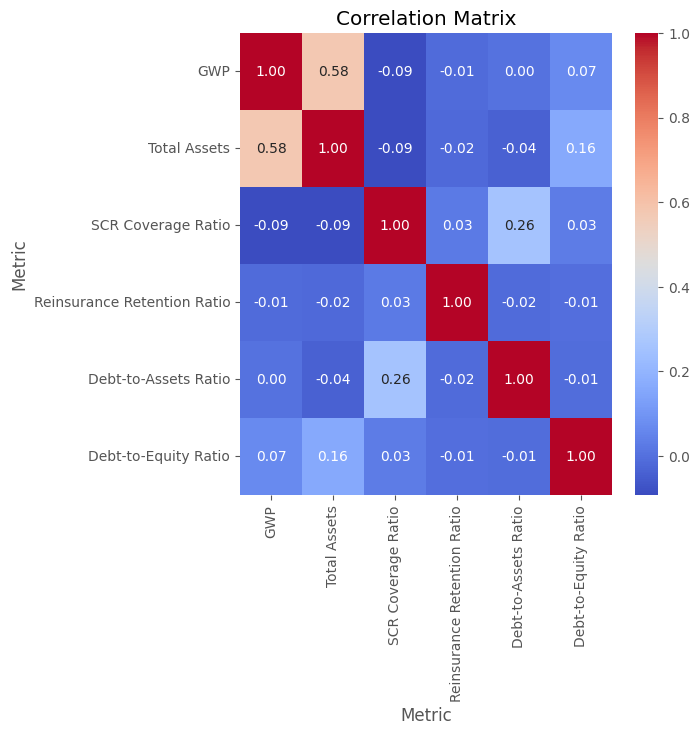

In [6]:
# Generate a correlation matrix
correlation_matrix = firms_features.corr()

# Visualise the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Normalisation

Normalise the features.

In [7]:
# Scale features
scaler = StandardScaler()
firms_features_normalised = scaler.fit_transform(firms_features)


## Outlier Detection

Use an `IsolationForest` in order to detect outliers and visualise the results.

In [8]:
# Use an IsolationForest to fit model to detect outliers
contamination_level = 0.05
model = IsolationForest(contamination=contamination_level, random_state=42)
model.fit(firms_features_normalised)

# Predict outliers
firms_copy = firms.copy()
firms_copy["Anomaly"] = model.predict(firms_features_normalised)

In [9]:
print(f"There are {(firms_copy['Anomaly'] == -1).sum()} outliers in the dataset.")

There are 13 outliers in the dataset.


Visualise the results of the anomaly detection, projected down into two dimensions.

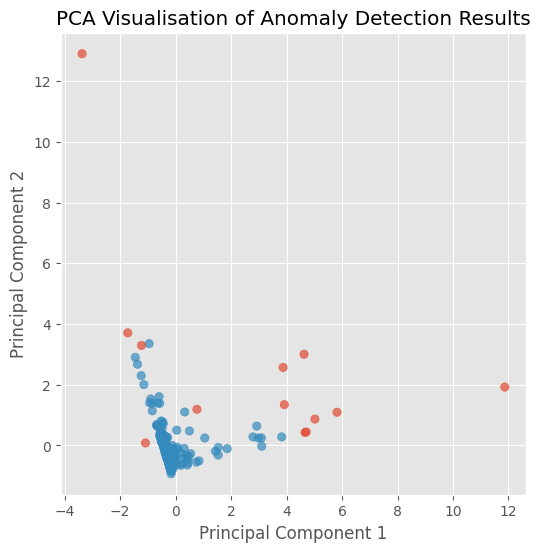

In [17]:
# Project data to two principal components
pca = PCA(n_components=2)
df_pca = pca.fit_transform(firms_features_normalised)
df_pca_anomaly = pd.DataFrame(data=df_pca, columns=["PC1", "PC2"])
df_pca_anomaly["Anomaly"] = firms_copy["Anomaly"].array

# Visualise the principal components
plt.figure(figsize=(6, 6))
colors = {-1: colours[0], 1: colours[1]}  # 0 for normal, 1 for anomaly
plt.scatter(df_pca_anomaly["PC1"], df_pca_anomaly["PC2"], c=df_pca_anomaly["Anomaly"].map(colors), alpha=0.7)
plt.title("PCA Visualisation of Anomaly Detection Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig(f"{CHARTS_DIR}/anomaly_pcr.png")
plt.show()

Print a list of the firms identified as outliers.

In [11]:
print(", ".join(firms_copy[firms_copy["Anomaly"] == -1].index))

Firm 10, Firm 151, Firm 163, Firm 205, Firm 210, Firm 247, Firm 25, Firm 278, Firm 311, Firm 34, Firm 4, Firm 51, Firm 53


Generate a table containing information about the outliers.

In [19]:
outliers = firms_features[firms_copy["Anomaly"] == -1]
display(outliers)
generate_markdown_table(outliers.round(2), f"{CHARTS_DIR}/outlier_detection_results.md")

Metric,GWP,Total Assets,SCR Coverage Ratio,Reinsurance Retention Ratio,Debt-to-Assets Ratio,Debt-to-Equity Ratio
Firm,,,,,,
Firm 10,882.479158,195835.579311,0.598787,0.251549,1.298387,28.058275
Firm 151,15824.692457,124326.020117,0.579234,0.350987,0.755972,129.506049
Firm 163,0.442528,0.054580,23.507181,1.262149,87.650759,2.834212
Firm 205,-0.001899,33.806305,4.718941,4410.456660,0.166386,0.396329
Firm 210,69697.928286,160518.698476,0.163691,0.870900,0.076797,10.969133
Firm 247,9115.194999,100085.096026,7.973924,0.021019,0.795871,5159.300538
Firm 25,7031.517005,3614.906667,3.155166,1.388834,8.422221,1124.696678
Firm 278,-0.003196,9.783135,24.752541,-5.238631,0.009934,14.013616
Firm 311,24251.481358,61836.611134,1.798395,0.600635,7.996857,61.886628


Markdown table has been generated and saved to 02 Figures/outlier_detection_results.md.


Visualise the outliers by plotting two of the features at a time.

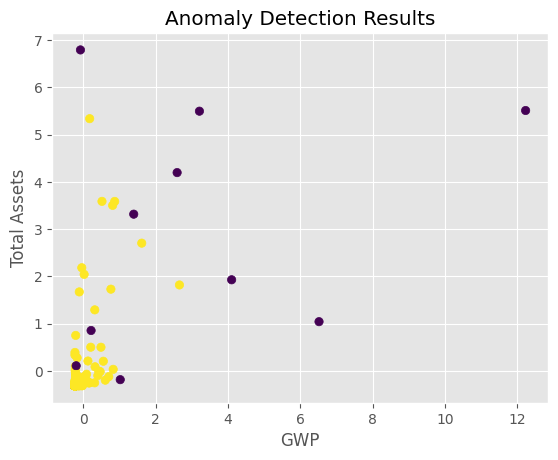

In [13]:
# Select features to visualise
feature_1_id = 0
feature_2_id = 1

# Visualise outlier firms on two metrics
plt.scatter(firms_features_normalised[:, feature_1_id], firms_features_normalised[:, feature_2_id], c=firms_copy["Anomaly"], cmap="viridis")
plt.title("Anomaly Detection Results")
plt.xlabel(firms_features.columns[feature_1_id])
plt.ylabel(firms_features.columns[feature_2_id])
plt.show()